# &#128013; 시각화를 활용한 노선 혼잡도 평가

<p style='text-align: right;'>제출용_국토도시 빅데이터 윈터스쿨[초급반]</p>
<p style='text-align: right;'>4조(강수정, 양명철, 김진수, 유승우])</p>

---

<font color="royalblue">Box plot</font>을 이용하여 시외 노선 별로 변동폭과 평균값의 분포를 확인한다.<br>
승차자 수가 평균값보다 높고, 변동폭이 큰 노선을 선정하여 혼잡도를 평가한다.<br>
이를 통해 전략적으로 배차간격를 늘리거나 줄여 효율적인 버스 운행의 기대효과를 볼 수 있다.<br>


### 목차

 분석 배경
    1. 제주 버스 이용 현황
        - 일 별 승차자 수
        - 요일 별 승차자 수
        
     2. 노선 평가 
        - boxplot
        - 버스 노선 id 31580000 분석
            - barplot 일별 분석
            - Pie chart 호차 분석
            - 지도를 통한 시각화 분석
        - 버스 노선 id 22540000 분석
     3. 결론 및 제언
     

최근 제주시가 시민들의 버스 이용의 불편 사항을 반영하여 버스 노선을 개편하였다.<br>
개편된 버스 노선이 효과적으로 운영되는지 boxplot을 통해 분석할 수 있다.

In [2]:
#-*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium

import os

try:
    os.chdir(r'C:\Users\KSJ\Desktop\conda_proj')
    print('Curren Working Directory is changed')
except OSError:
    print("can't change Current Working Diretory.")
    
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

Curren Working Directory is changed


In [4]:
# train.csv 불러오기
data = pd.read_csv('train.csv', encoding='utf8')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
id               415423 non-null int64
date             415423 non-null object
bus_route_id     415423 non-null int64
in_out           415423 non-null object
station_code     415423 non-null int64
station_name     415423 non-null object
latitude         415423 non-null float64
longitude        415423 non-null float64
6~7_ride         415423 non-null float64
7~8_ride         415423 non-null float64
8~9_ride         415423 non-null float64
9~10_ride        415423 non-null float64
10~11_ride       415423 non-null float64
11~12_ride       415423 non-null float64
6~7_takeoff      415423 non-null float64
7~8_takeoff      415423 non-null float64
8~9_takeoff      415423 non-null float64
9~10_takeoff     415423 non-null float64
10~11_takeoff    415423 non-null float64
11~12_takeoff    415423 non-null float64
18~20_ride       415423 non-null float64
dtypes: float64(15), int64(3), object

In [5]:
# object to datetime 변환
data['date'] = pd.to_datetime(data['date'])

In [6]:
# 요일 추가
data['weekday'] = data['date'].dt.weekday

In [7]:
# 시내, 시외 값 변환
data['in_out'] = data['in_out'].map({'시내':0,'시외':1})

In [9]:
# 시외인 행만 추출
bus_route_station_data_filter = data[ data['in_out'] == 1]

### 1. 제주 버스 이용 현황
        - 요일 별 승차자 수
        - 주말(토요일, 일요일)의 버스 이용자수가 저조함을 알 수 있다.

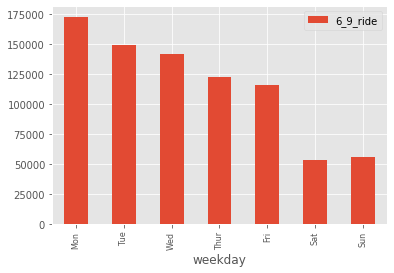

In [43]:
# 요일 별 6시~9시 승차자 수 
week_sum_df = data[['weekday','6~7_ride','7~8_ride','8~9_ride']]
week_sum_df['6_9_ride'] = week_sum_df['6~7_ride'] + week_sum_df['7~8_ride'] + week_sum_df['8~9_ride']
week_69_sum_df = week_sum_df.groupby(by=['weekday'])['6_9_ride'].sum()

week_69_sum_to_df = week_69_sum_df.to_frame().reset_index()

week_69_sum_to_df['weekday'] = ["Mon", "Tue", 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
week_69_sum_to_df.plot(kind='bar', x = 'weekday', y= '6_9_ride')
plt.show()

### 2. 노선 평가 
    - 주요 출근 시간(6시~9시)의 버스 이용자 수를 구한다.
    - 이를 통해 각 노선 별 버스 이용자 수의 Box plot(평균, 분산)을 구하기 위한 전처리 작업을 수행한다.
    


In [44]:
# 6시~9시 승차자 수 합산하여 열 추가
bus_route_station_data_filter['6_9_ride'] = bus_route_station_data_filter['6~7_ride'] + bus_route_station_data_filter['7~8_ride'] + bus_route_station_data_filter['8~9_ride']

In [47]:
# 날짜별(일자) 버스루트별 정류소별 버스 이용자 수(6시~9시)
bus_route_station_data_filter_groupby = bus_route_station_data_filter.groupby(by=['bus_route_id','date','station_code'])['6_9_ride'].sum()

In [48]:
# 6시~9시 모든 승차자 수 평균값 구하기
mean_line = np.mean(bus_route_station_data_filter['6_9_ride'])

In [49]:
# 버스 루트 id 중복 제거 작업
bus_route_station_data_filter['bus_route_id'].drop_duplicates()

0          4270000
25         4280000
61         8170000
81        20010000
91        20040000
            ...   
166271    31670000
227479    31550000
257478    29990000
327107    21450000
364927    26050000
Name: bus_route_id, Length: 156, dtype: int64

## Box plot
    - 1. Box plot을 통해 각 노선 별 평균, 변동 및 4 분위를 구한다. 
    - 2. 전체 버스 노선 평균 이용자 수를 구한다.
    - 3. 전체 버스 이용자 수 평균값과 각 노선 별 Box plot을 통해 노선을 평가할 수 있다.

* 노선 평가<br>
    - 전체 버스 이용자 수 평균값보다 값이 이용자 수가 적고 이용자들의 변동폭이 적으면 버스 노선이 효율적으로 운영되지 않음을 유추할 수 있다.<br> 
    이를 통해서 버스 노선간 배차 간격을 넓히는 방안을 고려한다. <br>
<br>

    - 반면, 전체 버스 이용자 수 평균값보다 값이 이용자 수가 많고, <br>
      이용자들의 변동폭이 적으면 버스 노선이 효율적으로 운영됨을 유추할 수 있다. <br>
      이를 통해서 버스 노선간 배차 간격을 좁히는 방법을 고려할 수 있다.<br><br>

    - 변동폭은 크지만 평균 탑승객 수가 많은 경우, 어느 정류장에서 변동 폭이 큰 지를 조사하여 효율성에 제고할 수 있다.

    - 변동폭은 크지만 평균 탑승객 수가 적은 경우, 올바르게 버스 노선이 구성되었는지를 제고해볼 필요가 있다.

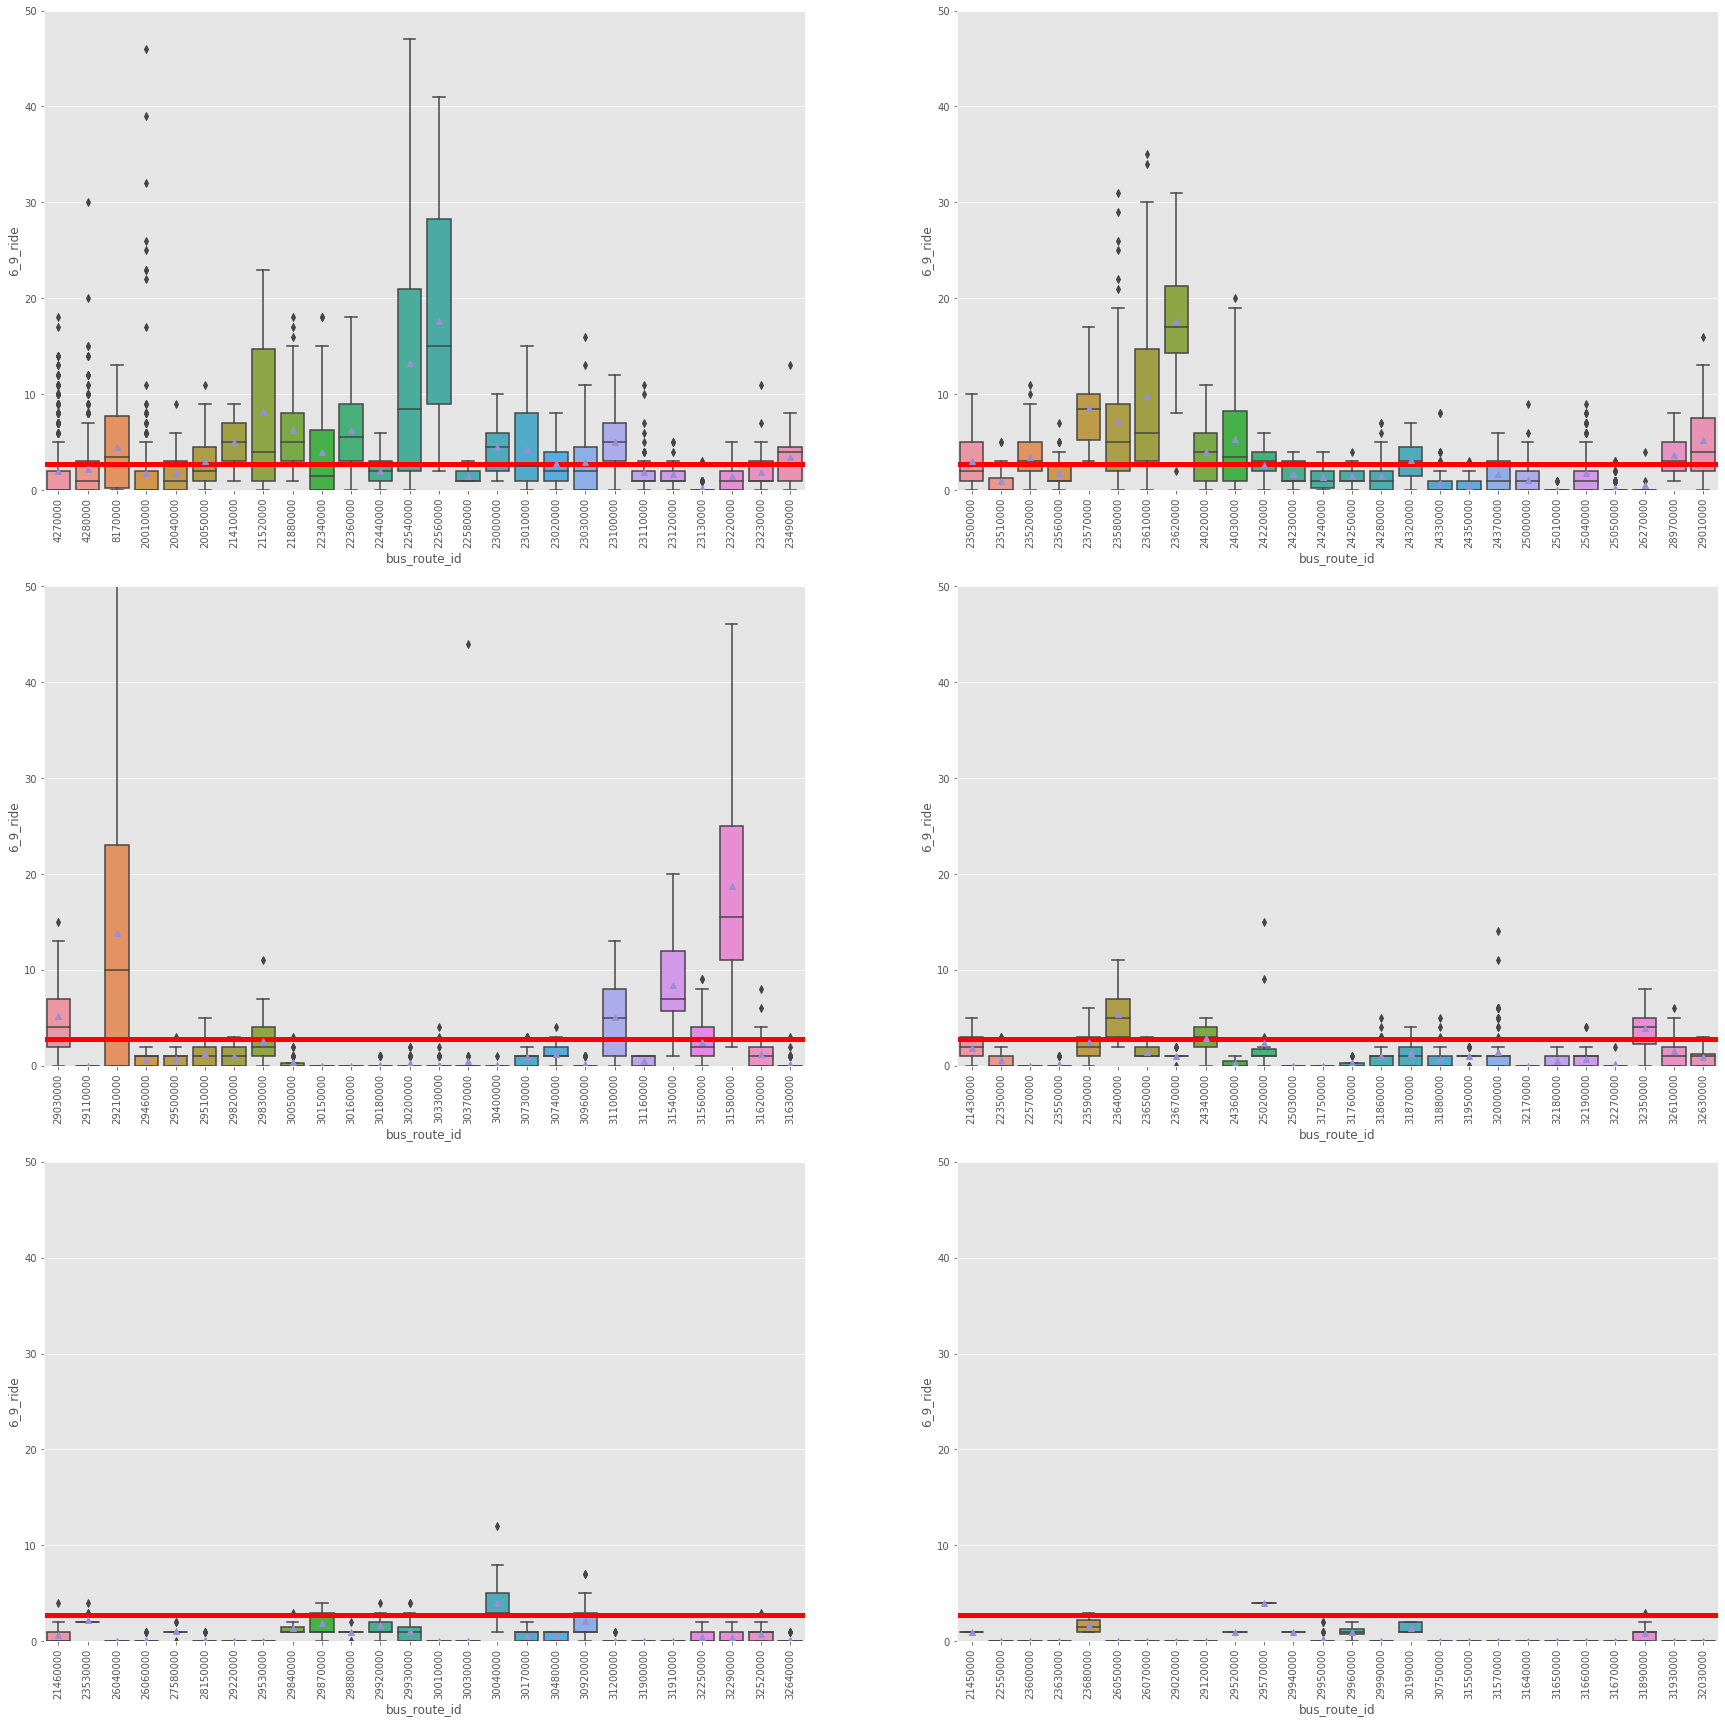

In [53]:
# box plot을 이용
# x축(버스 노선 id), y축(승차자 수)

# bus_route_id 중복 제거
bus_id = bus_route_station_data_filter['bus_route_id'].drop_duplicates()
bus_id = bus_id.tolist()

# subplot를 구성하기 위해 여러 리스트로 구성
group = []
group.append( bus_id[0:int(len(bus_id)/6)])
group.append( bus_id[int(len(bus_id)/6):int(len(bus_id)/6)*2])
group.append( bus_id[int(len(bus_id)/6*2):int(len(bus_id)/6)*3])
group.append( bus_id[int(len(bus_id)/6*3):int(len(bus_id)/6)*4])
group.append( bus_id[int(len(bus_id)/6*4):int(len(bus_id)/6)*5])
group.append( bus_id[int(len(bus_id)/6*5):int(len(bus_id)/6)*6])


bus_route_station_sum_df = bus_route_station_data_filter.groupby(by=['bus_route_id','date','station_code','in_out'])['6_9_ride'].sum()
bus_route_station_sum_df = bus_route_station_sum_df.to_frame().reset_index()

subplot_data1 = bus_route_station_sum_df[bus_route_station_sum_df['bus_route_id'].isin(group[0])]
subplot_data2 = bus_route_station_sum_df[bus_route_station_sum_df['bus_route_id'].isin(group[1])]
subplot_data3 = bus_route_station_sum_df[bus_route_station_sum_df['bus_route_id'].isin(group[2])]
subplot_data4 = bus_route_station_sum_df[bus_route_station_sum_df['bus_route_id'].isin(group[3])]
subplot_data5 = bus_route_station_sum_df[bus_route_station_sum_df['bus_route_id'].isin(group[4])]
subplot_data6 = bus_route_station_sum_df[bus_route_station_sum_df['bus_route_id'].isin(group[5])]

# subplot
plt.figure(figsize = (30,30))
plt.subplot(321)
sns.boxplot("bus_route_id","6_9_ride", data = subplot_data1, showmeans=True)
plt.axhline(y=mean_line, color='r', linewidth=5)
plt.xticks(rotation = 90)
plt.rc('xtick', labelsize = 10 )
plt.ylim([0,50])

plt.subplot(322)
sns.boxplot("bus_route_id","6_9_ride", data = subplot_data2, showmeans=True)
plt.axhline(y=mean_line, color='r', linewidth=5)
plt.xticks(rotation = 90)
plt.rc('xtick', labelsize = 10 )
plt.ylim([0,50])

plt.subplot(323)
sns.boxplot("bus_route_id","6_9_ride", data = subplot_data3, showmeans=True)
plt.axhline(y=mean_line, color='r', linewidth=5)
plt.xticks(rotation = 90)
plt.rc('xtick', labelsize = 10 )
plt.ylim([0,50])

plt.subplot(324)
sns.boxplot("bus_route_id","6_9_ride", data = subplot_data4, showmeans=True)
plt.axhline(y=mean_line, color='r', linewidth=5)
plt.xticks(rotation = 90)
plt.rc('xtick', labelsize = 10 )
plt.ylim([0,50])

plt.subplot(325)
sns.boxplot("bus_route_id","6_9_ride", data = subplot_data5, showmeans=True)
plt.axhline(y=mean_line, color='r', linewidth=5)
plt.xticks(rotation = 90)
plt.rc('xtick', labelsize = 10 )
plt.ylim([0,50])

plt.subplot(326)
sns.boxplot("bus_route_id","6_9_ride", data = subplot_data6, showmeans=True)
plt.axhline(y=mean_line, color='r', linewidth=5)
plt.xticks(rotation = 90)
plt.rc('xtick', labelsize = 10 )
plt.ylim([0,50])

plt.show()

## Boxplot 분석
    - 위의 red line은 전체 노선의 평균 이용자수를 의미한다.
    - red line 아래의 boxplot이 위치하여 버스 이용자 수가 적고, 
      변동폭이 적은 경우 버스 노선이 효율적으로 운영되지 않음을 유추할 수 있다.
      이를 통해 노선 간 배차 간격을 넓히는 방안을 고려할 수 있다.
      예를 들어, 맨 하단의 두개의 subplot의 대부분의 버스 노선이 그 예이다.
    - red line 위에 boxplot이 위치하여 버스 이용자 수가 많고, 
      변동폭이 큰 예인 버스 노선 id 31580000와 22540000 선택하여 분석하기로 한다.

### 1. 버스 노선 id 31580000 분석
    - 일별(1일~30일) 승차자 수 

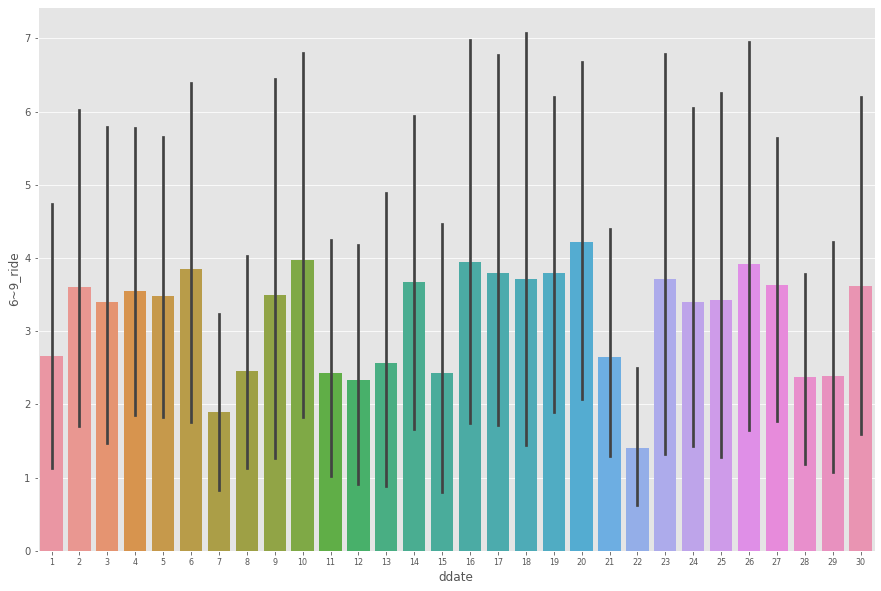

In [56]:
# 일별 6시~9시 승차자 수 
data['ddate'] = data['date'].dt.day

# 날짜, 노선, 승차자 수
m_count = data[['ddate','bus_route_id','6~7_ride','7~8_ride','8~9_ride','in_out']] 
m_count_filter = m_count[data['in_out'] == 1]
m_count_filter = m_count[data['bus_route_id'] == 31580000]

m_count_filter['6~9_ride'] = m_count['6~7_ride'] + m_count['7~8_ride'] + m_count['8~9_ride']

m_count_filter_groupby = m_count_filter.groupby(by=['ddate'])['6~9_ride'].sum()

plt.figure(figsize=(15, 10))
m_count_filter_groupby_df = m_count_filter_groupby = m_count_filter.groupby(by=['ddate'])['6~9_ride'].sum()
m_count_filter_groupby_df = m_count_filter_groupby_df.to_frame().reset_index()
sns.barplot('ddate','6~9_ride', data = m_count_filter)
plt.show()

## barplot 일별 분석
    - 9월 12일~15일까지 이용자 수가 저조함을 알 수 있다. 이에 원인은 추석의 영향으로 추론할 수 있다.
    - 9월 22일은 이용자 수가 적다. 이에 원인은 태풍의 영향으로 추론할 수 있다.

##  Pie chart 호차 분석
    - 버스 노선 31580000의 호차는 6개가 운영이 된다.
    - 호차 별로 평균 이용률을 알 수 있다.

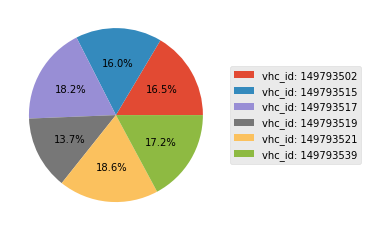

In [36]:
# 승차자 수가 많고, 변동량이 큰 버스 노선(31580000)에 호차별 비율 원그래프
bus_bts = pd.read_csv('bus_bts.csv', encoding='utf8')

bus_bts31580000 = bus_bts[bus_bts['bus_route_id'] == 31580000]

bus_bts31580000['num']=1
data31580000_filter_groupby = bus_bts31580000.groupby(by='vhc_id')['num'].sum()
data31580000_filter_groupby_index =data31580000_filter_groupby.to_frame().reset_index()
#파이 그래프
plt.pie(data31580000_filter_groupby,  autopct='%0.1f%%')

categories = ['vhc_id: 149793502', 'vhc_id: 149793515', 'vhc_id: 149793517', 'vhc_id: 149793519', 'vhc_id: 149793521', 'vhc_id: 149793539']

plt.legend(categories,loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

    - 정류장 별 승차지 분석

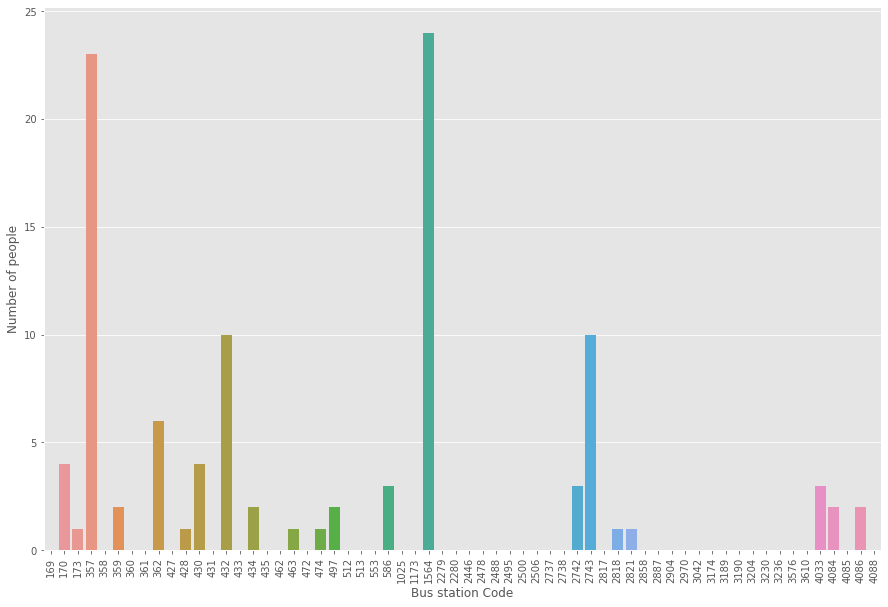

In [54]:
# 1. 승차자 수가 많고, 변동량이 큰 버스 노선(31580000) 선택
data[data['bus_route_id'] == 31580000].drop_duplicates('station_code')
data1 = data[data['bus_route_id'] == 31580000].drop_duplicates('station_code')
data1['6_9_ride'] = data1['6~7_ride'] + data1['7~8_ride'] + data1['8~9_ride']

# 2. 버스 노선 id가 31580000의 정류장 별 승차자 수
data1_sum = data1.groupby(by=['date','bus_route_id','station_code','in_out'])['6_9_ride'].sum()
data1_sum = data1_sum.to_frame().reset_index()

y = data1_sum['6_9_ride']
x = data1_sum['station_code']

plt.figure(figsize = (15,10))
sns.barplot(x = 'station_code' , y = '6_9_ride' , data = data1_sum)
plt.xlabel('Bus station Code')
plt.ylabel('Number of people')
plt.xticks(rotation = 90)
plt.rc('xtick', labelsize = 8)

x[np.argmax(y)]
plt.show()

### 정류장 별 분석 
    - 정류장 357과 1564는 다른 정류장보다 이용자수가 현저히 높은 값을 알 수 있다.

### 지도를 통한 시각화 분석
    - 버스 노선 ID 31580000의 정류장을 지도로 시각화하였다.
    - 가장 혼잡한 정류장 1564, 357, 432, 2743를 적색 아이콘으로 시각화하였다.


In [37]:
map_data = data[['bus_route_id','station_name','latitude','longitude','station_code']]
map_bus_route = map_data[map_data['bus_route_id'] == 31580000].drop_duplicates("station_code")
bus_station_busy = [1564, 357, 432, 2743]


map_osm = folium.Map(location=[33.4134, 126.5190], zoom_start = 10.5)


for item in map_bus_route.index:
    lat = map_bus_route.loc[item,'latitude']
    long = map_bus_route.loc[item,'longitude']
    
    
    if map_bus_route.loc[item,'station_code'] in bus_station_busy :
            folium.Marker([lat,long],popup = map_bus_route.loc[item,'station_name'],
                      icon = folium.Icon(color = 'red', icon = 'info-sign')
                      ).add_to(map_osm)
    else:
        folium.Marker([lat,long],popup = map_bus_route.loc[item,'station_name'],
                      icon = folium.Icon(icon = '')
                      ).add_to(map_osm)

    
#folium.PolyLine(map_bus_route[['latitude','longitude']]).add_to(map_osm)
map_osm

In [57]:
# 상위 4개의 혼잡한 정류장만 지도에 시각화
map_osm = folium.Map(location=[33.4134, 126.5190], zoom_start = 10.5)
map_bus_route = map_data[map_data['bus_route_id'] == 31580000].drop_duplicates("station_code")

for item in map_bus_route.index:
    lat = map_bus_route.loc[item,'latitude']
    long = map_bus_route.loc[item,'longitude']
    
    if map_bus_route.loc[item,'station_code'] in bus_station_busy :
            folium.Marker([lat,long],popup = map_bus_route.loc[item,'station_name'],
                      icon = folium.Icon(color = 'red', icon = 'info-sign')
                      ).add_to(map_osm)
  
        
map_osm

## 위의 그래프는 상위 4개의 혼잡한 정류장만 지도에 시각화

### 2. 버스 노선 id 22540000 분석
    - 정류장 별 버스 이용자 수 분석

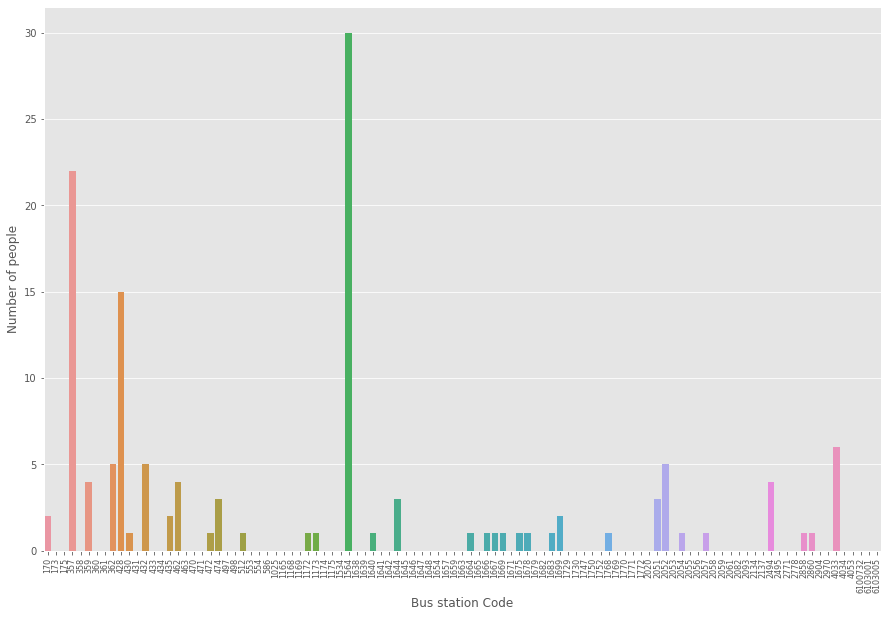

In [39]:
data[data['bus_route_id'] == 22540000].drop_duplicates('station_code')
data1 = data[data['bus_route_id'] == 22540000].drop_duplicates('station_code')
data1['6_9_ride'] = data1['6~7_ride'] + data1['7~8_ride'] + data1['8~9_ride']
data1_sum = data1.groupby(by=['date','bus_route_id','station_code','in_out'])['6_9_ride'].sum()
data1_sum = data1_sum.to_frame().reset_index()

y = data1_sum['6_9_ride']
x = data1_sum['station_code']

plt.figure(figsize = (15,10))
sns.barplot(x = 'station_code' , y = '6_9_ride' , data = data1_sum)
plt.xlabel('Bus station Code')
plt.ylabel('Number of people')
plt.xticks(rotation = 90)
plt.rc('xtick', labelsize = 8)

In [58]:
map_data = data[['bus_route_id','station_name','latitude','longitude','station_code']]
map_bus_route = map_data[map_data['bus_route_id'] == 22540000].drop_duplicates("station_code")
bus_station_busy = [1564, 357, 428]


map_osm = folium.Map(location=[33.4134, 126.5190], zoom_start = 10.5)


for item in map_bus_route.index:
    lat = map_bus_route.loc[item,'latitude']
    long = map_bus_route.loc[item,'longitude']
    
    
    if map_bus_route.loc[item,'station_code'] in bus_station_busy :
            folium.Marker([lat,long],popup = map_bus_route.loc[item,'station_name'],
                      icon = folium.Icon(color = 'red', icon = 'info-sign')
                      ).add_to(map_osm)
    else:
        folium.Marker([lat,long],popup = map_bus_route.loc[item,'station_name'],
                      icon = folium.Icon(icon = '')
                      ).add_to(map_osm)

    
#folium.PolyLine(map_bus_route[['latitude','longitude']]).add_to(map_osm)
map_osm

### 지도를 통한 시각화 분석
    - 버스 노선 ID 22540000 정류장을 지도로 시각화하였다.
    - 가장 혼잡한 정류장 1564, 357, 428를 적색 아이콘으로 시각화하였다.


In [41]:
map_data = data[['bus_route_id','station_name','latitude','longitude','station_code']]
map_bus_route = map_data[map_data['bus_route_id'] == 22540000].drop_duplicates("station_code")
bus_station_busy = [1564, 357, 428]


map_osm = folium.Map(location=[33.4134, 126.5190], zoom_start = 10.5)


for item in map_bus_route.index:
    lat = map_bus_route.loc[item,'latitude']
    long = map_bus_route.loc[item,'longitude']
    
    
    if map_bus_route.loc[item,'station_code'] in bus_station_busy :
            folium.Marker([lat,long],popup = map_bus_route.loc[item,'station_name'],
                      icon = folium.Icon(color = 'red', icon = 'info-sign')
                      ).add_to(map_osm)
    else:
        folium.Marker([lat,long],popup = map_bus_route.loc[item,'station_name'],
                      icon = folium.Icon(icon = '')
                      ).add_to(map_osm)

    
#folium.PolyLine(map_bus_route[['latitude','longitude']]).add_to(map_osm)
map_osm

## 결론 및 제언
    - 1. boxplot을 통해서 노선 혼잡도를 평가할 수 있다.
        -boxplot을 통해서 버스 노선의 혼잡도를 파악하고 이를 개선할 수 있다
    - 2. 이를 통해 혼잡한 버스 노선 31580000, 22540000을 시각화를 통해 살펴보았다.
    - 3. 시각화를 통해 시내의 정류장이 혼잡함을 알 수 있다.
        -추가적인 버스 배치를 통해 혼잡된 정류장의 문제를 개선할 수 있다.
        -혼잡한 버스 정류장에서는 버스를 우회하거나 새로운 노선을 추가하여 교통 문제를 개선할 수 있다.

향후 퇴근 시간에 대한 데이터를 통해서 버스 노선을 평가하여 더 나은 교통 환경을 제공할 수 있다.